In [102]:
import pandas as pd
import numpy as np
import requests
import json
import time
import os 

from scripts.vectology_functions import create_aaa_distances, create_pair_distances, embed_text, encode_traits
from nxontology import NXOntology

#from ontoma import OnToma
#otmap = OnToma()

import seaborn as sns

# Apply the default theme
sns.set_theme()

In [103]:
# files
ebi_data = 'data/UK_Biobank_master_file.tsv'
#efo_nodes = 'data/efo-nodes.tsv'
efo_data = 'data/efo_data.txt.gz'

In [104]:
# get the EBI UKB data
#get ebi data
#url='https://raw.githubusercontent.com/EBISPOT/EFO-UKB-mappings/master/UK_Biobank_master_file.tsv'
#ebi_df = pd.read_csv(url,sep='\t')

ebi_df = pd.read_csv(ebi_data,sep='\t')

#drop some columns
ebi_df = ebi_df[['ZOOMA QUERY','MAPPED_TERM_LABEL','MAPPED_TERM_URI']]
ebi_df.rename(columns={'ZOOMA QUERY':'query'},inplace=True)
print(ebi_df.head())
print(ebi_df.shape)

#create new rows for multiple labels
#ebi_df = (
#        ebi_df.assign(label=ebi_df.MAPPED_TERM_LABEL.str.split("\|\|"))
#        .explode("label")
#        .reset_index(drop=True).drop('MAPPED_TERM_LABEL',axis=1)
#    )

#create new rows for multiple ids
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|\|',',')
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|',',')
ebi_df = (
        ebi_df.assign(id=ebi_df.MAPPED_TERM_URI.str.split(","))
        .explode("id")
        .reset_index(drop=True).drop('MAPPED_TERM_URI',axis=1)
    )

#clean up
ebi_df['id'] = ebi_df['id'].str.strip()

#drop cases where query and id are the same
ebi_df.drop_duplicates(subset=['query','id'],inplace=True)
print(ebi_df.shape)

#drop nan
ebi_df.dropna(inplace=True)
print(ebi_df.shape)
print(ebi_df.head())


                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            MAPPED_TERM_URI  
0  EFO_0004264, EFO_0009431  
1               EFO_0004616  
2               EFO_0003778  
3               EFO_0003901  
4               EFO_0004247  
(1565, 3)
(1613, 3)
(1600, 3)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4       

In [105]:
%%time

# get EFO node data
#efo_df=pd.read_csv(efo_nodes,sep='\t',names=['name','label','type'])
#print(efo_df.head())
#print(efo_df.shape)

# EFO data
efo_df = pd.read_json(efo_data)
#print(efo_df.head())
node_data = []
for i,rows in efo_df.iterrows():
    node_data.append({
        'id':rows['child']['value'],
        'name':rows['childLabel']['value'],
    })
    node_data.append({
        'id':rows['parent']['value'],
        'name':rows['parentLabel']['value'],
        
    })
efo_node_df = pd.DataFrame(node_data)
efo_node_df.drop_duplicates(inplace=True)
print(efo_node_df)

                                              id  \
0           http://www.ebi.ac.uk/efo/EFO_0004285   
1      http://purl.obolibrary.org/obo/HP_0000093   
2           http://www.ebi.ac.uk/efo/EFO_0004207   
3      http://purl.obolibrary.org/obo/HP_0000545   
4           http://www.ebi.ac.uk/efo/EFO_0002608   
...                                          ...   
53112  http://purl.obolibrary.org/obo/HP_0002840   
53114  http://purl.obolibrary.org/obo/PO_0030015   
53118  http://purl.obolibrary.org/obo/EO_0007068   
53120  http://purl.obolibrary.org/obo/HP_0002313   
53124   http://purl.obolibrary.org/obo/FMA_24984   

                                      name  
0                              albuminuria  
1                              Proteinuria  
2                      pathological myopia  
3                                   Myopia  
4                            AIDS dementia  
...                                    ...  
53112                        lymphadenitis  
53114  sporophy

In [106]:
#check all terms in EBI data set are in EFO node data
efo_node_ids = list(efo_node_df['id'])
ebi_ids = list(ebi_df['id'])
missing=[]
matched = []
for i in ebi_ids:
    match = False
    for s in efo_node_ids:
        if i in s and match == False:
            matched.append(s)
            match = True
    if match == False:
        missing.append(i)
print('Missing:',len(missing))

# remove missing from ukb data
print(ebi_df.shape)
for i in missing:
    ebi_df = ebi_df.drop(ebi_df[ebi_df['id'].str.contains(i)].index)
ebi_df['full_id'] = matched
print(ebi_df.head())
print(ebi_df.shape)
ebi_df.to_csv('output/ebi-ukb-cleaned.tsv',index=False,sep='\t')


Missing: 517
(1600, 3)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   
5                                Other mood           mood disorder   

            id                               full_id  
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264  
2  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616  
3  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778  
4  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901  
5  EFO_0004247  http://www.ebi.ac.uk/efo/EFO_0004247  
(1083, 4)


In [107]:
# preprocess
process_text=[]
for k,g in ebi_df.groupby(np.arange(len(ebi_df))//20):
    params={'text_list':list(g['query'])}
    process_res = requests.post('http://vectology-api.mrcieu.ac.uk/preprocess',data=json.dumps(params))
    process_text.extend([d['result'].replace('unspecified','').replace('nec','') for d in process_res.json()])
print(len(process_text))
    
ebi_df.loc[:, 'processed'] = process_text
print(ebi_df.head())

1083
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   
5                                Other mood           mood disorder   

            id                               full_id  \
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264   
2  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616   
3  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778   
4  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901   
5  EFO_0004247  http://www.ebi.ac.uk/efo/EFO_0004247   

                                  processed  
0           vascular disorders of intestine  
2                              gonarthrosis  
3  psoriatic and enteropathic arthropathies  
4          pain associated with micturition  
5

In [120]:
%%time

f='output/ebi-ukb-vec.tsv.gz'
if os.path.exists(f):
    print('Already done')
    ebi_df = pd.read_csv(f,sep='\t')
    #issues with reading vectors from CSV 
    ebi_df['BioSentVec'] = ebi_df['BioSentVec'].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
    ebi_df['BioBERT'] = ebi_df['BioBERT'].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
    ebi_df['BlueBERT'] = ebi_df['BlueBERT'].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
else:
    ebi_df = encode_traits(trait_df=ebi_df,col='processed',name='BioSentVec',model='BioSentVec')
    ebi_df = encode_traits(trait_df=ebi_df,col='processed',name='BioBERT',model='biobert_v1.1_pubmed')
    ebi_df = encode_traits(trait_df=ebi_df,col='processed',name='BlueBERT',model='NCBI_BERT_pubmed_mimic_uncased_L-12_H-768_A-12')
    ebi_df.to_csv(f,sep='\t',compression='gzip',index=False)

print(ebi_df.head())
print(ebi_df.shape)

Already done
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            id                               full_id  \
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264   
1  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616   
2  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778   
3  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901   
4  EFO_0004247  http://www.ebi.ac.uk/efo/EFO_0004247   

                                  processed  \
0           vascular disorders of intestine   
1                              gonarthrosis   
2  psoriatic and enteropathic arthropathies   
3          pain associated with mic

In [121]:
%%time

# takes ~30 mins for each BERT based model

#test
#efo_node_df = efo_node_df.head(n=5000)

f='output/efo-vec.tsv.gz'
if os.path.exists(f):
    print('Already done')
    efo_df = pd.read_csv(f,sep='\t')
    #issues with reading vectors from CSV 
    efo_df['BioSentVec'] = efo_df['BioSentVec'].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
    #efo_df['BioBERT'] = efo_df['BioBERT'].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
    efo_df['BlueBERT'] = efo_df['BlueBERT'].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
else:
    efo_df = encode_traits(trait_df=efo_node_df,col='name',name='BioSentVec',model='BioSentVec')
    efo_df = encode_traits(trait_df=efo_node_df,col='name',name='BioBERT',model='biobert_v1.1_pubmed')
    efo_df = encode_traits(trait_df=efo_node_df,col='name',name='BlueBERT',model='NCBI_BERT_pubmed_mimic_uncased_L-12_H-768_A-12')
    efo_df.to_csv(f,sep='\t',compression='gzip',index=False)
    
efo_df = encode_traits(trait_df=efo_node_df,col='name',name='BioBERT',model='biobert_v1.1_pubmed')
efo_df.to_csv(f,sep='\t',compression='gzip',index=False)    
print(efo_df.head())


Already done
1000 21865
2000 21865
3000 21865
4000 21865
5000 21865
6000 21865
7000 21865
8000 21865
9000 21865
10000 21865
11000 21865
12000 21865
13000 21865
14000 21865
15000 21865
16000 21865
17000 21865
18000 21865
19000 21865
20000 21865
21000 21865
21865 vectors created
                                          id                 name  \
0       http://www.ebi.ac.uk/efo/EFO_0004285          albuminuria   
1  http://purl.obolibrary.org/obo/HP_0000093          Proteinuria   
2       http://www.ebi.ac.uk/efo/EFO_0004207  pathological myopia   
3  http://purl.obolibrary.org/obo/HP_0000545               Myopia   
4       http://www.ebi.ac.uk/efo/EFO_0002608        AIDS dementia   

                                          BioSentVec  \
0  [0.4202117919921875, -0.17832736670970917, -1....   
1  [0.4231119751930237, -0.4265417158603668, -0.9...   
2  [0.39966529607772827, -0.34570133686065674, -0...   
3  [0.5090897083282471, -0.6281495094299316, -1.8...   
4  [0.9064940214157104, 0.2

In [111]:
#create nxontology network of EFO relationships
def create_efo_nxo() -> NXOntology:
    nxo = NXOntology()
    
    edges = []
    efo_rel_df=pd.read_json(efo_data)
    for i,row in efo_rel_df.iterrows():
        child = row['child']['value']
        parent = row['parent']['value']
        edges.append((parent,child))
    #print(edges[0:10])
    nxo.graph.add_edges_from(edges)
    return nxo

efo_nx = create_efo_nxo()
efo_nx.freeze()

In [122]:
%%time
def run_pairs(model):
    #ebi_df['BioSentVec']
    v1 = list(ebi_df[model])

    v2 = list(efo_df[model])
    # cosine of all against all
    dd = create_pair_distances(v1,v2)
    return dd
    
dd_bio = run_pairs('BioSentVec')
dd_bert = run_pairs('BlueBERT')
dd_biobert = run_pairs('BioBERT')

Creating distances...
1083 21865
1083
Creating distances...
1083 21865
1083
Creating distances...
1083 21865
1083
CPU times: user 1min 1s, sys: 1.01 s, total: 1min 2s
Wall time: 1min 2s


BioSentVec greater than 0.8: (621, 14)
BlueBERT greater than 0.8: (572, 14)
BioBERT greater than 0.8: (558, 14)


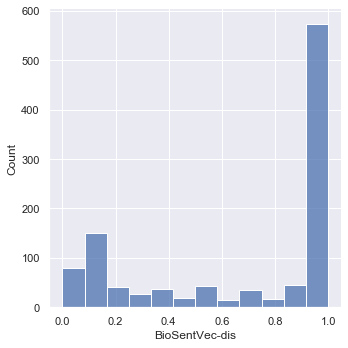

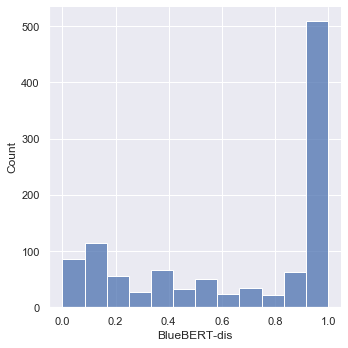

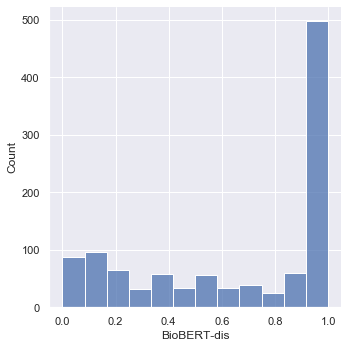

In [126]:
def get_top(model,pairwise_data):
    count=0
    dis_results=[]
    efo_map = []
    for i,irows in ebi_df.iterrows():
        #print('\nEBI:',count,irows[['query','MAPPED_TERM_LABEL','full_id']].values)
        try:
            min_dis = np.nanargmin(pairwise_data[count])
            min_val = np.nanmin(pairwise_data[count])
        except:
            min_dis=0
        #print('EFO:',efo_df.iloc[min_dis][['name','id']].values,min_val)
        try:
            res = similarity = efo_nx.similarity(irows['full_id'],efo_df.iloc[min_dis]['id']).results()
            #print(res['batet'])
            dis_results.append(res['batet'])
            efo_map.append(efo_df.iloc[min_dis]['id'])
        except:
            print('something wrong')
            exit()
        count+=1
    ebi_df[f'{model}-dis']=dis_results
    ebi_df[f'{model}-efo']=efo_map
    #print(ebi_df.head())
    print(model,'greater than 0.8:',ebi_df[ebi_df[f'{model}-dis']>0.8].shape)
    #plot
    sns_plot = sns.displot(ebi_df, x=f"{model}-dis")
    sns_plot.savefig(f"output/{model}-batet-dis.pdf")
get_top('BioSentVec',dd_bio)
get_top('BlueBERT',dd_bert)
get_top('BioBERT',dd_biobert)

In [70]:
# ontoma 
#print(otmap.find_term('Vascular disorders of intestine'))
#think this is just using zooma

In [71]:
# zooma using web app
# ran the web app using filtered list of terms
# Configure Data Sources - Don't search in any datasources checked
# Configure Ontology Sources - EFO
# https://www.ebi.ac.uk/spot/zooma
zooma_df = pd.read_csv('data/zooma.tsv',sep='\t')
zooma_df['zooma_efo'] = zooma_df['ONTOLOGY(S)']+zooma_df['ONTOLOGY TERM(S)']
zooma_df.drop_duplicates(subset=['zooma_efo'],inplace=True)
print(zooma_df.shape)

(929, 10)


In [72]:
# zooma using API
def run_zooma(text):
    zooma_api = 'https://www.ebi.ac.uk/spot/zooma/v2/api/services/annotate'
    payload = {
        'propertyValue':text,
        'filter':'required:[none],ontologies:[efo]'
    }
    res = requests.get(zooma_api,params=payload).json()
    if res:
        #print(text,res[0]['semanticTags'])
        return res[0]['semanticTags'][0]
    else:
        return 'NA'

In [73]:
%%time

# takes around 3 minutes for 1,000
f='output/ebi-zooma-api.tsv'
if os.path.exists(f):
    ebi_df_zooma = pd.read_csv(f,sep='\t')
else:
    ebi_df_zooma['zooma_api'] = ebi_df_zooma['query'].apply(lambda x:run_zooma(x))
    ebi_df_zooma.to_csv('output/ebi-zooma-api.tsv',sep='\t',index=False)
print(ebi_df_zooma.head())

                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            id                               full_id  \
0  EFO_0004264  http://www.ebi.ac.uk/efo/EFO_0004264   
1  EFO_0004616  http://www.ebi.ac.uk/efo/EFO_0004616   
2  EFO_0003778  http://www.ebi.ac.uk/efo/EFO_0003778   
3  EFO_0003901  http://www.ebi.ac.uk/efo/EFO_0003901   
4  EFO_0004247  http://www.ebi.ac.uk/efo/EFO_0004247   

                                  processed  \
0           vascular disorders of intestine   
1                              gonarthrosis   
2  psoriatic and enteropathic arthropathies   
3          pain associated with micturition   
4

1083
(549, 13)


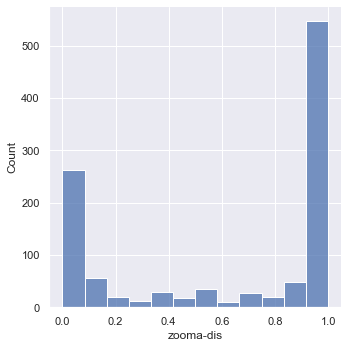

In [94]:
#print(zooma_df.head())

# merge with ebi file
#m = pd.merge(zooma_df,ebi_df,left_on='PROPERTY VALUE',right_on='query')
#m.drop_duplicates(inplace=True)
#print(m.head())
#print(m.shape)

dis_results=[]
for i, row in ebi_df_zooma.iterrows():
    try:
        res = similarity = efo_nx.similarity(row['zooma_api'],row['full_id']).results()
        #print(res['batet'])
        dis_results.append(res['batet'])
    except:
        dis_results.append(0)
        
print(len(dis_results))
ebi_df['zooma-dis'] = dis_results
print(ebi_df[ebi_df['zooma-dis']>0.9].shape)
ebi_df.to_csv('output/ebi-dis.tsv',sep='\t',index=False)
sns.displot(ebi_df, x="zooma-dis")

In [101]:
# compare the methods
# which values does BioSentVec map but zooma does not?

bb1 = ebi_df[(ebi_df['BioSentVec-dis']==1) & (ebi_df['zooma-dis']<0.8)]
print(bb1.shape)

bb2 = ebi_df[(ebi_df['zooma-dis']==1) & (ebi_df['BioSentVec-dis']<0.8)]
print(bb2[['query','MAPPED_TERM_LABEL','full_id','BioSentVec-dis','BioSentVec-efo']])

(141, 13)
                                                  query  \
25                       Hypertrophic disorders of skin   
93             Unspecified human immunodeficiency virus   
94                            Other endocrine disorders   
95                              Other diseases of liver   
135                    Premature separation of placenta   
...                                                 ...   
1440  Gestational [pregnancy-induced] hypertension w...   
1532  Postprocedural disorders of digestive system, ...   
1541          Other diseases of upper respiratory tract   
1607  Other disorders involving the immune mechanism...   
1620                   Other disorders of adrenal gland   

               MAPPED_TERM_LABEL                               full_id  \
25                  skin disease  http://www.ebi.ac.uk/efo/EFO_0000701   
93                 HIV infection  http://www.ebi.ac.uk/efo/EFO_0000764   
94      endocrine system disease  http://www.ebi.ac.uk/efo/